<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 1*

# 📝 Assignment
---

# 설치 파일
주석 해제, 실행 후 런타임 재시작.

In [3]:
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# !pip install category_encoders

# Decision Trees(결정트리)

## 캐글 인클래스(InClass) Competitions

### 1) EDA를 수행합시다

- [캐글 계정을 만드세요](https://www.kaggle.com/), 공유된 인클래스 대회 url을 통해 이동한 후 대회에 참여하세요.
- H1N1 데이터를 훈련/검증/테스트 셋으로 나누어 준비하세요
- profiling을 사용하여 데이터를 살펴보고, missing value, zeros, cardinarity 등을 확인하여 처리하세요.
- 본인만의 특성공학을 수행하세요.
- **(객관식) H1N1 분류기의 기준모델을 설정하세요. 기준모델의 정확도를 과제 제출폼에 제출하세요.**
    1. 0.24
    2. 0.50
    3. 0.76
    4. 1


# 데이터 불러오기

In [4]:
import pandas as pd

target = 'vacc_h1n1_f'

train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [5]:
train.head().T.head(10)

0  1  2  3  4
h1n1_concern                 NaN  3  2  2  1
h1n1_knowledge               NaN  1  1  2  2
behavioral_antiviral_meds    NaN  0  0  1  0
behavioral_avoidance         NaN  0  1  1  1
behavioral_face_mask         NaN  0  0  0  0
behavioral_wash_hands        NaN  1  1  1  1
behavioral_large_gatherings  NaN  0  1  0  0
behavioral_outside_home      NaN  0  0  0  0
behavioral_touch_face        NaN  1  1  0  1
doctor_recc_h1n1               0  0  0  0  0

In [6]:
train.shape

(42154, 39)

# 데이터 분석
결측치, 데이터 확인 후 훈련, 검증, 테스트 세트로 나누겠습니다.

In [38]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/52 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 데이터 프로파일링
## Variable Types
 - Categorical : 37 개
 - Numeric : 2 개

## Dataset 특징
 - Feature 개수 : 39 개
 - 샘플 개수 : 42154 개
 - 결측치 개수 : 256,993 개
 - 결측셀 비율 : 15.6%

## Variables
설문조사 데이터이기 때문에 너무 많아 생략.

numeric 변수 : n_people_r, hhs_region

categorical 변수 중 15개 이상의 카테고리들을 가지는 변수 : employment_industry (23 개), employment_occupation (25 개), state (51 개)

위의 5개의 feature들은 조정이 필요 해 보임.

카테고리가 많은 변수들은 분리 후 테스트를 진행 해 보겠습니다.

# 데이터 셋 변형

In [8]:
def engineer(df):
  import pandas as pd
  df = df[[i for i in df.columns if len(df[i].value_counts()) <= 10]]
  return df

In [9]:
train.shape, test.shape

((42154, 39), (28104, 38))

In [10]:
engineer(train).shape, engineer(test).shape

((42154, 36), (28104, 35))

# 트레인, 검증, 테스트 셋으로 분리

In [11]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(engineer(train), train_size=0.80, test_size=0.20, 
                                        stratify=train[target], random_state=2)
test_data = engineer(test)

X_train = train_data.drop(target, axis = 1)
y_train = train_data[target]

X_val = val_data.drop(target, axis = 1)
y_val = val_data[target]

X_test = test_data

train_data.shape, val_data.shape, test_data.shape

((33723, 36), (8431, 36), (28104, 35))

# 기준모델 생성

In [12]:
y_train.value_counts()

0    25661
1     8062
Name: vacc_h1n1_f, dtype: int64

타겟의 값중 0의 빈도수가 높으니 0으로 예측을 해보도록 하겠습니다.

In [14]:
# mode(): Return the highest frequency value in a Series.
major = y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만듭니다. 기준모델로 예측
y_pred = [major] * len(y_train)

# 최다 클래스의 빈도가 정확도가 됩니다.
from sklearn.metrics import accuracy_score
print("training accuracy: ", accuracy_score(y_train, y_pred))

# 검증세트 에서도 정확도를 확인해 볼 수 있습니다.
y_pred = [major] * len(y_val)
print("validation accuracy: ", accuracy_score(y_val, y_pred))

training accuracy:  0.7609346736648578
validation accuracy:  0.7610010674890286


### 2) 모델 개발
- 결정트리를 학습시킵니다. 하이퍼파라미터를 수정하여 성능을 높여보세요. 과적합을 주의하세요!

1.   항목 추가
2.   항목 추가


- 검증세트 스코어를 확인하세요.(평가지표는 F1-score입니다, 수식은 캐글 Overview-Evaluation 페이지를 확인해 주세요. 평가지표에 대한 내용은 다음에 자세히 배우고 활용할 것입니다 지금은 스코어를 올리기 위한 노력을 전혀 기울이지 말고 결정트리의 개념과 코드이해, 사용에 집중하세요!)
- 특성중요도를 그래프로 나타내 보세요
- **검증세트의 F1-score를 과제 제출폼에 제출하세요. (0.5 이상 통과)**

# 모델 생성

In [15]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegression(n_jobs=-1)
)
pipe.fit(X_train, y_train)

print('검증세트 정확도', pipe.score(X_val, y_val))

y_pred = pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증세트 정확도 0.8211362827659827


In [16]:
score = []
i = 0

from sklearn.tree import DecisionTreeClassifier
score = []
i = 1
while True:
  if i == 1:
    pipe = make_pipeline(
        OneHotEncoder(use_cat_names=True),  
        SimpleImputer(), 
        DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth = i)
    )
    pipe.fit(X_train, y_train)
    score.append([pipe.score(X_val, y_val), i])
    i += 1
  else:
    pipe = make_pipeline(
        OneHotEncoder(use_cat_names=True),  
        SimpleImputer(), 
        DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth = i)
    )
    pipe.fit(X_train, y_train)
    score.append([pipe.score(X_val, y_val), i])
    if score[-1][0] == score[-2][0]:
      break
    i += 1

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

In [17]:
sorted(score, reverse = True)[0]

[0.8269481674771676, 7]

트리를 7개 사용 했을 때, 가장 높은 검증 데이터의 정확도가 가장 높습니다.

In [18]:
score[-2]

[0.7576799905112086, 44]

최종으로 분리된 트리의 개수는 44개 입니다.

In [19]:
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth = 7)
)
pipe.fit(X_train, y_train)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.8300862912552264
검증 정확도:  0.8269481674771676


In [20]:
y_val_pred = pipe.predict(X_val)

In [21]:
from sklearn.metrics import f1_score

f1_score(y_val, y_val_pred, average='macro')

0.7188367611565198

In [22]:
f1_score(y_val, y_val_pred, average='micro')

0.8269481674771676

In [23]:
f1_score(y_val, y_val_pred, average='weighted')


0.8098463822768662

In [24]:
f1_score(y_val, y_val_pred, average=None)

array([0.89318398, 0.54448954])

In [25]:
f1_score(y_val, y_val_pred, average='binary')

0.5444895410552608

### 3) 캐글 대회 참여

- 테스트셋에 대한 예측 결과를 캐글에 제출 하세요.(스코어가 많이 낮게 나와도 결정트리를 잘 이해하고 결과를 내었다면 충분합니다!)
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**
 

In [26]:
y_test = pipe.predict(X_test)
y_test.shape

(28104,)

In [27]:
result = pd.DataFrame({'id' : range(len(y_test)), 'vacc_h1n1_f' : y_test})
result

id  vacc_h1n1_f
0          0            0
1          1            0
2          2            0
3          3            0
4          4            0
...      ...          ...
28099  28099            0
28100  28100            0
28101  28101            0
28102  28102            0
28103  28103            0

[28104 rows x 2 columns]

In [ ]:
result.to_csv('y_test.csv', index=False)

## 🔥 도전과제

### 4) 다른 종류의 imputer를 사용하고 특성-타겟 관계 그래프를 나타내 보세요.
- 다른 종류의 imputer를 사용해 보세요([scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html))
- seaborn plots 사용하여 관심있는 특성들과 target간의 관계를 그래프로 나타내 보세요.
- [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html)
- [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html)

# 다변량 기능 대치

In [28]:
from category_encoders import OneHotEncoder
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OneHotEncoder(), 
    IterativeImputer(max_iter=10, random_state=0), 
    StandardScaler(), 
    LogisticRegression(n_jobs=-1)
)
pipe.fit(X_train, y_train)

print('검증세트 정확도', pipe.score(X_val, y_val))

y_pred = pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증세트 정확도 0.8195943541691377


# 가장 가까운 이웃 대치

In [29]:
from sklearn.impute import KNNImputer

pipe = make_pipeline(
    OneHotEncoder(), 
    KNNImputer(n_neighbors=2, weights="uniform"), 
    StandardScaler(), 
    LogisticRegression(n_jobs=-1)
)
pipe.fit(X_train, y_train)

print('검증세트 정확도', pipe.score(X_val, y_val))

y_pred = pipe.predict(X_test)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증세트 정확도 0.8175779860040328


# 데이터 시각화

In [31]:
train.head()

h1n1_concern  h1n1_knowledge  ...          state  vacc_h1n1_f
0           NaN             NaN  ...     CALIFORNIA            0
1           3.0             1.0  ...       NEBRASKA            0
2           2.0             1.0  ...  MASSACHUSETTS            0
3           2.0             2.0  ...      LOUISIANA            0
4           1.0             2.0  ...        ALABAMA            1

[5 rows x 39 columns]

catplot!

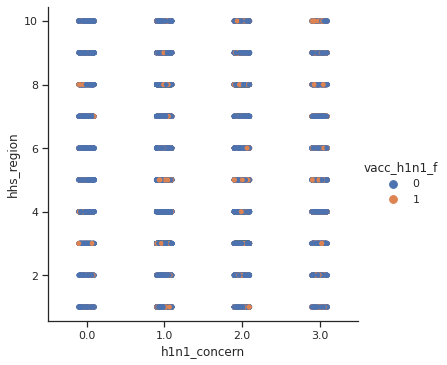

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

sns.catplot(x="h1n1_concern", y="hhs_region", hue = 'vacc_h1n1_f', data=train);

violin plot 마음에 드는데 !! 너무 오래 걸린다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 95.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 98.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 98.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 96.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


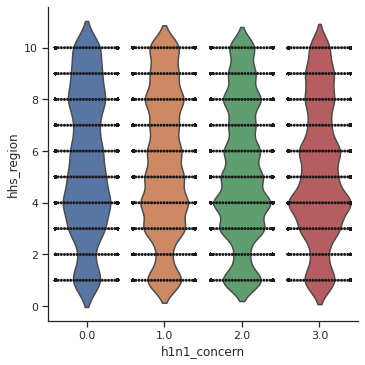

In [41]:
# 생각보다 꽤 오래 걸림;;;;
g = sns.catplot(x="h1n1_concern", y="hhs_region", kind="violin", inner=None, data=train);
sns.swarmplot(x="h1n1_concern", y="hhs_region", color="k", size=3, data=train, ax=g.ax);

손 씻는 빈도와 마스크 착용 유무의 사람간의 감염자 수를 한번 확인 해 보겠습니다.

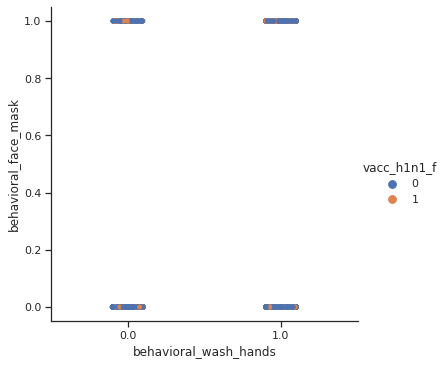

In [42]:
sns.set_theme(style="ticks", color_codes=True)

sns.catplot(x="behavioral_wash_hands", y="behavioral_face_mask", hue = 'vacc_h1n1_f', data=train);

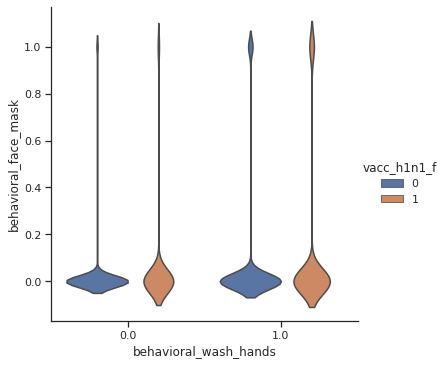

In [43]:
sns.catplot(x="behavioral_wash_hands", y="behavioral_face_mask", hue = 'vacc_h1n1_f', kind="violin", inner=None, data=train);

pairplot ! ;; 대부분 이진 데이터들이라 의미가 별로 없당..

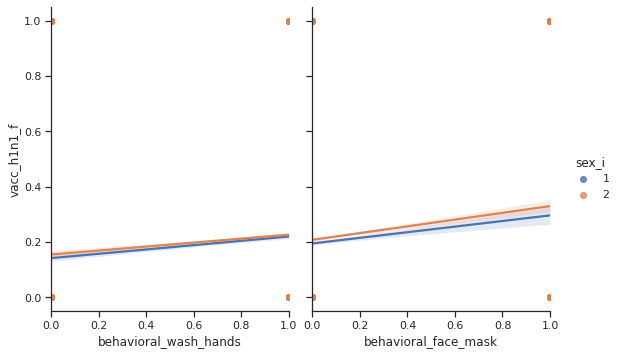

In [46]:
sns.pairplot(train, x_vars=["behavioral_wash_hands", "behavioral_face_mask"], y_vars=["vacc_h1n1_f"],
             hue="sex_i", height=5, aspect=.8, kind="reg");

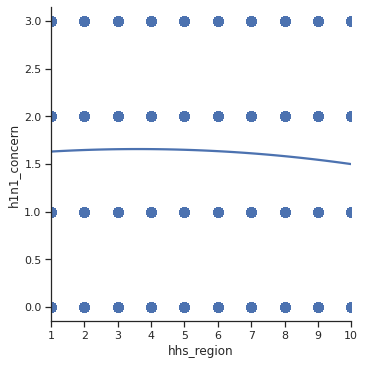

In [53]:
sns.lmplot(x="hhs_region", y="h1n1_concern", data=train,
           order=2, ci=None, scatter_kws={"s": 80});

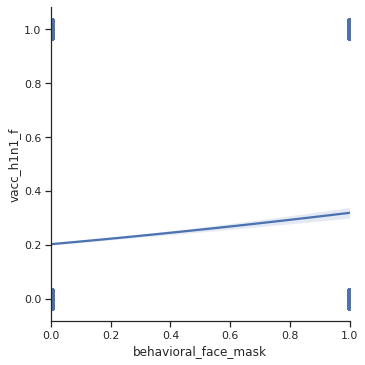

In [54]:
sns.lmplot(x="behavioral_face_mask", y="vacc_h1n1_f", data=train,
           logistic=True, y_jitter=.03);

Float 변수 있을 때 사용 하면 좋을 듯 싶다 !